In [19]:
!pip install -q transformers

!pip install -q datasets

!pip install -q evaluate

!pip install -q accelerate

!pip install -q gluonts ujson

!pip install -q matplotlib


[notice] A new release of pip is available: 23.0.1 -> 24.0
[notice] To update, run: python.exe -m pip install --upgrade pip

[notice] A new release of pip is available: 23.0.1 -> 24.0
[notice] To update, run: python.exe -m pip install --upgrade pip

[notice] A new release of pip is available: 23.0.1 -> 24.0
[notice] To update, run: python.exe -m pip install --upgrade pip

[notice] A new release of pip is available: 23.0.1 -> 24.0
[notice] To update, run: python.exe -m pip install --upgrade pip

[notice] A new release of pip is available: 23.0.1 -> 24.0
[notice] To update, run: python.exe -m pip install --upgrade pip

[notice] A new release of pip is available: 23.0.1 -> 24.0
[notice] To update, run: python.exe -m pip install --upgrade pip


In [20]:
from datasets import load_dataset

dataset = load_dataset("monash_tsf", "tourism_monthly")
dataset


DatasetDict({
    train: Dataset({
        features: ['start', 'target', 'feat_static_cat', 'feat_dynamic_real', 'item_id'],
        num_rows: 366
    })
    test: Dataset({
        features: ['start', 'target', 'feat_static_cat', 'feat_dynamic_real', 'item_id'],
        num_rows: 366
    })
    validation: Dataset({
        features: ['start', 'target', 'feat_static_cat', 'feat_dynamic_real', 'item_id'],
        num_rows: 366
    })
})

In [21]:
# The start simply indicates the start of the time series (as a datetime), and the target contains the actual values of the time series.
freq = "1M"
prediction_length = 24

train_example = dataset['train'][0]
validation_example = dataset['validation'][0]

# The validation set contains the same data as the training set, just for a prediction_length longer amount of time.
# The test set is again one prediction_length longer data compared to the validation set
assert len(train_example["target"]) + prediction_length == len(
    validation_example["target"]
)

print(len(train_example["target"]))

139


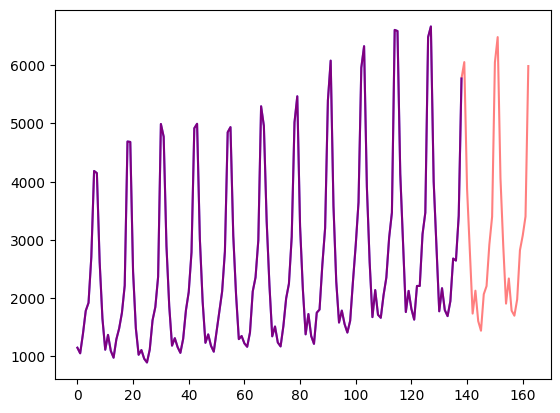

In [22]:
import matplotlib.pyplot as plt

figure, axes = plt.subplots()
axes.plot(train_example["target"], color="blue")
axes.plot(validation_example["target"], color="red", alpha=0.5)

plt.show()


In [23]:
train_dataset = dataset["train"]
test_dataset = dataset["test"]

In [24]:
#Update start to period

from functools import lru_cache

import pandas as pd
import numpy as np

@lru_cache(10_000)
def convert_to_pandas_period(date, freq):
    return pd.Period(date, freq)

def transform_start_field(batch, freq):
    batch["start"] = [convert_to_pandas_period(date, freq) for date in batch["start"]]
    return batch


In [25]:
from functools import partial

print(train_dataset)
train_dataset.set_transform(partial(transform_start_field, freq=freq))
test_dataset.set_transform(partial(transform_start_field, freq=freq))

Dataset({
    features: ['start', 'target', 'feat_static_cat', 'feat_dynamic_real', 'item_id'],
    num_rows: 366
})


In [26]:
from gluonts.time_feature import get_lags_for_frequency

lags_sequence = get_lags_for_frequency(freq)
print(lags_sequence)
# This means that we'll look back up to 37 months for each time step, as additional features.

[1, 2, 3, 4, 5, 6, 7, 11, 12, 13, 23, 24, 25, 35, 36, 37]


In [27]:
from gluonts.time_feature import time_features_from_frequency_str

time_features = time_features_from_frequency_str(freq)
print(time_features)

# In this case, there's only a single feature, namely "month of year". 
# This means that for each time step, we'll add the month as a scalar value 
# (e.g. 1 in case the timestamp is "january", 2 in case the timestamp is "february", etc.).

[<function month_of_year at 0x000001F3225BB370>]


In [28]:
# Model definition

from transformers import TimeSeriesTransformerConfig, TimeSeriesTransformerForPrediction

config = TimeSeriesTransformerConfig(
    prediction_length=prediction_length,
    # context length:
    context_length=prediction_length * 2,
    
    # lags coming from helper given the freq:
    lags_sequence=lags_sequence,
    
    # we'll add 2 time features ("month of year" and "age", see further):
    num_time_features=len(time_features) + 1,
    
    # we have a single static categorical feature, namely time series ID:
    num_static_categorical_features=1,
    
    # it has 366 possible values:
    cardinality=[len(train_dataset)],
    
    # the model will learn an embedding of size 2 for each of the 366 possible values:
    embedding_dimension=[2],
    
    # transformer params:
    encoder_layers=4,
    decoder_layers=4,
    d_model=32,
)

model = TimeSeriesTransformerForPrediction(config)


In [29]:
# Note that, similar to other models in the 🤗 Transformers library, TimeSeriesTransformerModel corresponds to the encoder-decoder Transformer without any head on top, 
# and TimeSeriesTransformerForPrediction corresponds to TimeSeriesTransformerModel with a distribution head on top.
model.config.distribution_output

'student_t'

In [30]:
# data transformations

from gluonts.time_feature import (
    time_features_from_frequency_str,
    TimeFeature,
    get_lags_for_frequency,
)
from gluonts.dataset.field_names import FieldName
from gluonts.transform import (
    AddAgeFeature,
    AddObservedValuesIndicator,
    AddTimeFeatures,
    AsNumpyArray,
    Chain,
    ExpectedNumInstanceSampler,
    InstanceSplitter,
    RemoveFields,
    SelectFields,
    SetField,
    TestSplitSampler,
    Transformation,
    ValidationSplitSampler,
    VstackFeatures,
    RenameFields,
)

In [31]:
from transformers import PretrainedConfig

def create_transformation(freq: str, config: PretrainedConfig) -> Transformation:
    remove_field_names = []
    if config.num_static_real_features == 0:
        remove_field_names.append(FieldName.FEAT_STATIC_REAL)
    if config.num_dynamic_real_features == 0:
        remove_field_names.append(FieldName.FEAT_DYNAMIC_REAL)
    if config.num_static_categorical_features == 0:
        remove_field_names.append(FieldName.FEAT_STATIC_CAT)

    # a bit like torchvision.transforms.Compose
    return Chain(
        # step 1: remove static/dynamic fields if not specified
        [RemoveFields(field_names=remove_field_names)]
        # step 2: convert the data to NumPy (potentially not needed)
        + (
            [
                AsNumpyArray(
                    field=FieldName.FEAT_STATIC_CAT,
                    expected_ndim=1,
                    dtype=int,
                )
            ]
            if config.num_static_categorical_features > 0
            else []
        )
        + (
            [
                AsNumpyArray(
                    field=FieldName.FEAT_STATIC_REAL,
                    expected_ndim=1,
                )
            ]
            if config.num_static_real_features > 0
            else []
        )
        + [
            AsNumpyArray(
                field=FieldName.TARGET,
                # we expect an extra dim for the multivariate case:
                expected_ndim=1 if config.input_size == 1 else 2,
            ),
            # step 3: handle the NaN's by filling in the target with zero
            # and return the mask (which is in the observed values)
            # true for observed values, false for nan's
            # the decoder uses this mask (no loss is incurred for unobserved values)
            # see loss_weights inside the xxxForPrediction model
            AddObservedValuesIndicator(
                target_field=FieldName.TARGET,
                output_field=FieldName.OBSERVED_VALUES,
            ),
            # step 4: add temporal features based on freq of the dataset
            # month of year in the case when freq="M"
            # these serve as positional encodings
            AddTimeFeatures(
                start_field=FieldName.START,
                target_field=FieldName.TARGET,
                output_field=FieldName.FEAT_TIME,
                time_features=time_features_from_frequency_str(freq),
                pred_length=config.prediction_length,
            ),
            # step 5: add another temporal feature (just a single number)
            # tells the model where in its life the value of the time series is,
            # sort of a running counter
            AddAgeFeature(
                target_field=FieldName.TARGET,
                output_field=FieldName.FEAT_AGE,
                pred_length=config.prediction_length,
                log_scale=True,
            ),
            # step 6: vertically stack all the temporal features into the key FEAT_TIME
            VstackFeatures(
                output_field=FieldName.FEAT_TIME,
                input_fields=[FieldName.FEAT_TIME, FieldName.FEAT_AGE]
                + (
                    [FieldName.FEAT_DYNAMIC_REAL]
                    if config.num_dynamic_real_features > 0
                    else []
                ),
            ),
            # step 7: rename to match HuggingFace names
            RenameFields(
                mapping={
                    FieldName.FEAT_STATIC_CAT: "static_categorical_features",
                    FieldName.FEAT_STATIC_REAL: "static_real_features",
                    FieldName.FEAT_TIME: "time_features",
                    FieldName.TARGET: "values",
                    FieldName.OBSERVED_VALUES: "observed_mask",
                }
            ),
        ]
    )


In [32]:
# For training/validation/testing we next create an InstanceSplitter which is used to sample windows from the dataset 
# (as, remember, we can't pass the entire history of values to the Transformer due to time- and memory constraints).

#The instance splitter samples random context_length sized and subsequent prediction_length sized windows from the data, 
# and appends a past_ or future_ key to any temporal keys in time_series_fields for the respective windows. 
# The instance splitter can be configured into three different modes:
#       mode="train": Here we sample the context and prediction length windows randomly from the dataset given to it (the training dataset)
#       mode="validation": Here we sample the very last context length window and prediction window from the dataset given to it (for the back-testing or validation likelihood calculations)
#       mode="test": Here we sample the very last context length window only (for the prediction use case)

from gluonts.transform.sampler import InstanceSampler
from typing import Optional

def create_instance_splitter(
    config: PretrainedConfig,
    mode: str,
    train_sampler: Optional[InstanceSampler] = None,
    validation_sampler: Optional[InstanceSampler] = None,
) -> Transformation:
    assert mode in ["train", "validation", "test"]

    instance_sampler = {
        "train": train_sampler
        or ExpectedNumInstanceSampler(
            num_instances=1.0, min_future=config.prediction_length
        ),
        "validation": validation_sampler
        or ValidationSplitSampler(min_future=config.prediction_length),
        "test": TestSplitSampler(),
    }[mode]

    return InstanceSplitter(
        target_field="values",
        is_pad_field=FieldName.IS_PAD,
        start_field=FieldName.START,
        forecast_start_field=FieldName.FORECAST_START,
        instance_sampler=instance_sampler,
        past_length=config.context_length + max(config.lags_sequence),
        future_length=config.prediction_length,
        time_series_fields=["time_features", "observed_mask"],
    )


In [33]:
from typing import Iterable

import torch
from gluonts.itertools import Cached, Cyclic
from gluonts.dataset.loader import as_stacked_batches


def create_train_dataloader(
    config: PretrainedConfig,
    freq,
    data,
    batch_size: int,
    num_batches_per_epoch: int,
    shuffle_buffer_length: Optional[int] = None,
    cache_data: bool = True,
    **kwargs,
) -> Iterable:
    PREDICTION_INPUT_NAMES = [
        "past_time_features",
        "past_values",
        "past_observed_mask",
        "future_time_features",
    ]
    if config.num_static_categorical_features > 0:
        PREDICTION_INPUT_NAMES.append("static_categorical_features")

    if config.num_static_real_features > 0:
        PREDICTION_INPUT_NAMES.append("static_real_features")

    TRAINING_INPUT_NAMES = PREDICTION_INPUT_NAMES + [
        "future_values",
        "future_observed_mask",
    ]

    transformation = create_transformation(freq, config)
    transformed_data = transformation.apply(data, is_train=True)
    if cache_data:
        transformed_data = Cached(transformed_data)

    # we initialize a Training instance
    instance_splitter = create_instance_splitter(config, "train")

    # the instance splitter will sample a window of
    # context length + lags + prediction length (from the 366 possible transformed time series)
    # randomly from within the target time series and return an iterator.
    stream = Cyclic(transformed_data).stream()
    training_instances = instance_splitter.apply(stream)
    
    return as_stacked_batches(
        training_instances,
        batch_size=batch_size,
        shuffle_buffer_length=shuffle_buffer_length,
        field_names=TRAINING_INPUT_NAMES,
        output_type=torch.tensor,
        num_batches_per_epoch=num_batches_per_epoch,
    )


In [34]:
def create_test_dataloader(
    config: PretrainedConfig,
    freq,
    data,
    batch_size: int,
    **kwargs,
):
    PREDICTION_INPUT_NAMES = [
        "past_time_features",
        "past_values",
        "past_observed_mask",
        "future_time_features",
    ]
    if config.num_static_categorical_features > 0:
        PREDICTION_INPUT_NAMES.append("static_categorical_features")

    if config.num_static_real_features > 0:
        PREDICTION_INPUT_NAMES.append("static_real_features")

    transformation = create_transformation(freq, config)
    transformed_data = transformation.apply(data, is_train=False)

    # We create a test Instance splitter to sample the very last
    # context window from the dataset provided.
    instance_sampler = create_instance_splitter(config, "test")

    # We apply the transformations in test mode
    testing_instances = instance_sampler.apply(transformed_data, is_train=False)
    
    return as_stacked_batches(
        testing_instances,
        batch_size=batch_size,
        output_type=torch.tensor,
        field_names=PREDICTION_INPUT_NAMES,
    )



In [36]:
train_dataloader = create_train_dataloader(
    config=config,
    freq=freq,
    data=train_dataset,
    batch_size=256,
    num_batches_per_epoch=100,
)

test_dataloader = create_test_dataloader(
    config=config,
    freq=freq,
    data=test_dataset,
    batch_size=64,
)


In [43]:
batch = next(iter(train_dataloader))
for k, v in batch.items():
    print(k, v.shape, v.type()) # feature, targets, mask,
    
# As can be seen, we don't feed input_ids and attention_mask to the encoder (as would be the case for NLP models), 
# but rather past_values, along with past_observed_mask, past_time_features, and static_categorical_features.

# The decoder inputs consist of future_values, future_observed_mask and future_time_features. 
# The future_values can be seen as the equivalent of decoder_input_ids in NLP.

past_time_features torch.Size([256, 85, 2]) torch.FloatTensor
past_values torch.Size([256, 85]) torch.FloatTensor
past_observed_mask torch.Size([256, 85]) torch.FloatTensor
future_time_features torch.Size([256, 24, 2]) torch.FloatTensor
static_categorical_features torch.Size([256, 1]) torch.IntTensor
future_values torch.Size([256, 24]) torch.FloatTensor
future_observed_mask torch.Size([256, 24]) torch.FloatTensor


In [44]:
# perform a single forward pass
outputs = model(
    past_values=batch["past_values"],
    past_time_features=batch["past_time_features"],
    past_observed_mask=batch["past_observed_mask"],
    static_categorical_features=batch["static_categorical_features"]
    if config.num_static_categorical_features > 0
    else None,
    static_real_features=batch["static_real_features"]
    if config.num_static_real_features > 0
    else None,
    future_values=batch["future_values"],
    future_time_features=batch["future_time_features"],
    future_observed_mask=batch["future_observed_mask"],
    output_hidden_states=True,
)


In [45]:
print("Loss:", outputs.loss.item())


Loss: 9.228050231933594


In [ ]:
# train model 

from accelerate import Accelerator
from torch.optim import AdamW

accelerator = Accelerator()
device = accelerator.device

model.to(device)
optimizer = AdamW(model.parameters(), lr=6e-4, betas=(0.9, 0.95), weight_decay=1e-1)

model, optimizer, train_dataloader = accelerator.prepare(
    model,
    optimizer,
    train_dataloader,
)

model.train()
for epoch in range(40):
    for idx, batch in enumerate(train_dataloader):
        optimizer.zero_grad()
        outputs = model(
            static_categorical_features=batch["static_categorical_features"].to(device)
            if config.num_static_categorical_features > 0
            else None,
            static_real_features=batch["static_real_features"].to(device)
            if config.num_static_real_features > 0
            else None,
            past_time_features=batch["past_time_features"].to(device),
            past_values=batch["past_values"].to(device),
            future_time_features=batch["future_time_features"].to(device),
            future_values=batch["future_values"].to(device),
            past_observed_mask=batch["past_observed_mask"].to(device),
            future_observed_mask=batch["future_observed_mask"].to(device),
        )
        loss = outputs.loss

        # Backpropagation
        accelerator.backward(loss)
        optimizer.step()

        if idx % 100 == 0:
            print(loss.item())


9.11340618133545
7.4560065269470215
7.876840114593506
7.874261379241943
6.750526428222656
7.1197991371154785
7.196831226348877
7.754628658294678
7.493295192718506
7.592381000518799
6.957479476928711
7.165857791900635
7.552195072174072
6.994785308837891
7.150243282318115
6.7387518882751465
6.883329391479492
7.624871730804443
7.1186299324035645
7.5138702392578125
6.619601726531982
6.958765029907227
7.084909915924072
7.615786075592041
7.41157865524292
6.75243616104126
7.433635711669922
7.228176593780518
6.877847194671631
7.510398864746094
7.416520595550537
6.9922966957092285
6.968774318695068
7.085293292999268
6.853921890258789
7.228492259979248
7.161899566650391
6.8150787353515625
6.982522964477539
7.374271392822266


In [ ]:
# inference

model.eval()

forecasts = []

for batch in test_dataloader:
    outputs = model.generate(
        static_categorical_features=batch["static_categorical_features"].to(device)
        if config.num_static_categorical_features > 0
        else None,
        static_real_features=batch["static_real_features"].to(device)
        if config.num_static_real_features > 0
        else None,
        past_time_features=batch["past_time_features"].to(device),
        past_values=batch["past_values"].to(device),
        future_time_features=batch["future_time_features"].to(device),
        past_observed_mask=batch["past_observed_mask"].to(device),
    )
    forecasts.append(outputs.sequences.cpu().numpy())


In [ ]:
forecasts[0].shape

(64, 100, 24)

In [ ]:
forecasts = np.vstack(forecasts)
print(forecasts.shape)

(366, 100, 24)


In [ ]:
!pip install scikit-learn

     ---------------------------------------- 0.0/10.6 MB ? eta -:--:--
     -- ------------------------------------- 0.6/10.6 MB 19.5 MB/s eta 0:00:01
     ----- ---------------------------------- 1.5/10.6 MB 18.8 MB/s eta 0:00:01
     --------- ------------------------------ 2.5/10.6 MB 22.3 MB/s eta 0:00:01
     ---------- ----------------------------- 2.7/10.6 MB 21.4 MB/s eta 0:00:01
     ---------- ----------------------------- 2.7/10.6 MB 21.4 MB/s eta 0:00:01
     ---------- ----------------------------- 2.9/10.6 MB 12.2 MB/s eta 0:00:01
     ------------- -------------------------- 3.5/10.6 MB 12.4 MB/s eta 0:00:01
     ----------------- ---------------------- 4.6/10.6 MB 14.6 MB/s eta 0:00:01
     --------------------- ------------------ 5.8/10.6 MB 16.0 MB/s eta 0:00:01
     ------------------------- -------------- 6.9/10.6 MB 16.9 MB/s eta 0:00:01
     ------------------------------ --------- 8.0/10.6 MB 17.6 MB/s eta 0:00:01
     ----------------------------------- ---- 9.


[notice] A new release of pip is available: 23.0.1 -> 24.0
[notice] To update, run: python.exe -m pip install --upgrade pip


In [ ]:
from evaluate import load
from gluonts.time_feature import get_seasonality

mase_metric = load("evaluate-metric/mase")
smape_metric = load("evaluate-metric/smape")

forecast_median = np.median(forecasts, 1)

mase_metrics = []
smape_metrics = []
for item_id, ts in enumerate(test_dataset):
    training_data = ts["target"][:-prediction_length]
    ground_truth = ts["target"][-prediction_length:]
    mase = mase_metric.compute(
        predictions=forecast_median[item_id], 
        references=np.array(ground_truth), 
        training=np.array(training_data), 
        periodicity=get_seasonality(freq))
    mase_metrics.append(mase["mase"])
    
    smape = smape_metric.compute(
        predictions=forecast_median[item_id], 
        references=np.array(ground_truth), 
    )
    smape_metrics.append(smape["smape"])


In [ ]:
print(f"MASE: {np.mean(mase_metrics)}")
print(f"sMAPE: {np.mean(smape_metrics)}")

MASE: 1.659417920469183
sMAPE: 0.20505665812003987


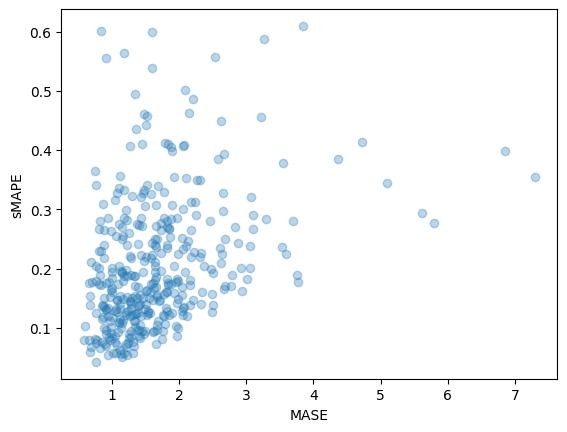

In [ ]:
plt.scatter(mase_metrics, smape_metrics, alpha=0.3)
plt.xlabel("MASE")
plt.ylabel("sMAPE")
plt.show()

In [ ]:
import matplotlib.dates as mdates

def plot(ts_index):
    fig, ax = plt.subplots()

    index = pd.period_range(
        start=test_dataset[ts_index][FieldName.START],
        periods=len(test_dataset[ts_index][FieldName.TARGET]),
        freq=freq,
    ).to_timestamp()

    # Major ticks every half year, minor ticks every month,
    ax.xaxis.set_major_locator(mdates.MonthLocator(bymonth=(1, 7)))
    ax.xaxis.set_minor_locator(mdates.MonthLocator())

    ax.plot(
        index[-2*prediction_length:], 
        test_dataset[ts_index]["target"][-2*prediction_length:],
        label="actual",
    )

    plt.plot(
        index[-prediction_length:], 
        np.median(forecasts[ts_index], axis=0),
        label="median",
    )
    
    plt.fill_between(
        index[-prediction_length:],
        forecasts[ts_index].mean(0) - forecasts[ts_index].std(axis=0), 
        forecasts[ts_index].mean(0) + forecasts[ts_index].std(axis=0), 
        alpha=0.3, 
        interpolate=True,
        label="+/- 1-std",
    )
    plt.legend()
    plt.show()


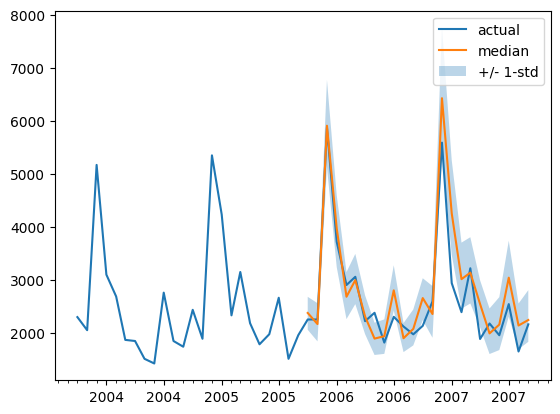

In [ ]:
plot(334)
